In [1]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [2]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Guassian Process Regression

In [3]:
class Gaussian_Regression:
    
    def __init__ (self, x_train, y_train, x_test, y_test, 
                  l = 10, 
                  scale = 1e-8):
        
        # init data
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test 
        
        # init hyperparameters
        self.l = l
        self.scale = scale
        
    def kernel(self, x, y):
        euc = np.sum(x**2, axis = 1, keepdims = True) - 2*x.dot(y.T) + np.sum(y**2, axis = 1) 
        return np.exp(-euc*(1 / (2 * self.l**2)))
        
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])    
    
    def MAE(self, y_pred, y_test):
        return (np.mean(np.abs(y_pred - y_test)))
    
    def train(self, x_train, y_train):
        
        # feed training data into kernel
        K = self.kernel(x_train, x_train)
        I = np.identity(x_train.shape[0])
        self.L = np.linalg.cholesky(K + self.scale*I)

        return
    
    def predict(self, x_test):
        
        # apply to test data
        K_star = self.kernel(self.x_train, x_test)
        L_k_star = np.linalg.solve(self.L, K_star)
        y_pred = L_k_star.T.dot( np.linalg.solve(self.L, self.y_train) )
        
        # calc std dev / uncertainty from samples
        K_star_star = self.kernel(x_test, x_test)
        variance = np.diag(K_star_star) - np.sum(L_k_star**2, axis=0)
        std = np.sqrt(variance)
        
        MSE = self.MSE(y_pred, self.y_test)
        
        return y_pred, MSE, std

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

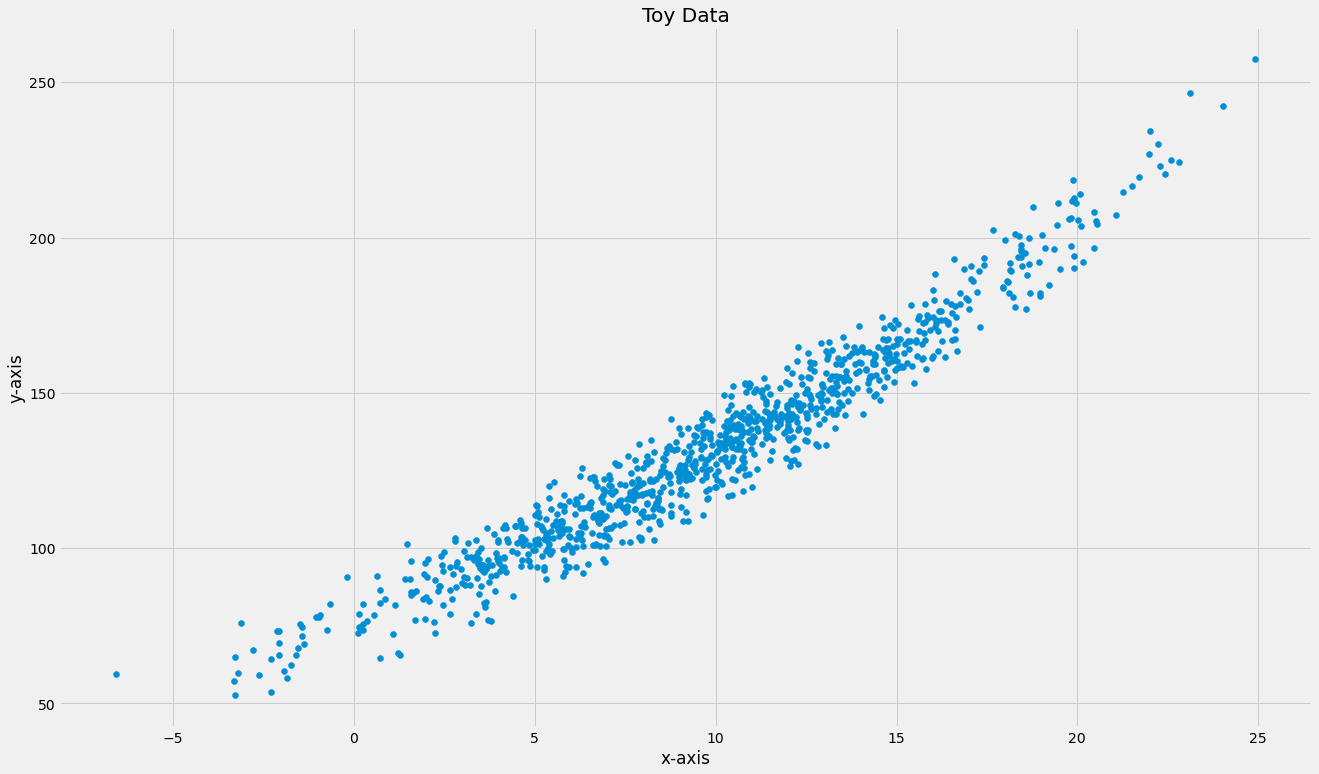

In [127]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    y_actual = []
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
            y_actual.append(a*x[i] + b)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            y_actual.append(a*x[i]**exp + b*x[i] + c)
            
    return x, y, y_actual
    
x, y, y_actual = f_toy(normal = True, linear = False)
plt.scatter(x,y)
#plt.scatter(x,y_actual, c = 'b', linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [128]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

# convert data to array format for model fitting
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [129]:
# create Gaussian Process class
GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = 100, 
                         scale = 1e-10)
# train model
GP.train(x_train, y_train)

# apply trained model to test data
y_pred, MSE, std = GP.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.02797791882661449


In [130]:
# unnormalize
x_test = unnormalize(x_test, test[1]['x'], test[2]['x']), 
y_test = unnormalize(y_test, test[1]['y'],  test[2]['y'])
y_pred = unnormalize(y_pred, test[1]['y'],  test[2]['y'])

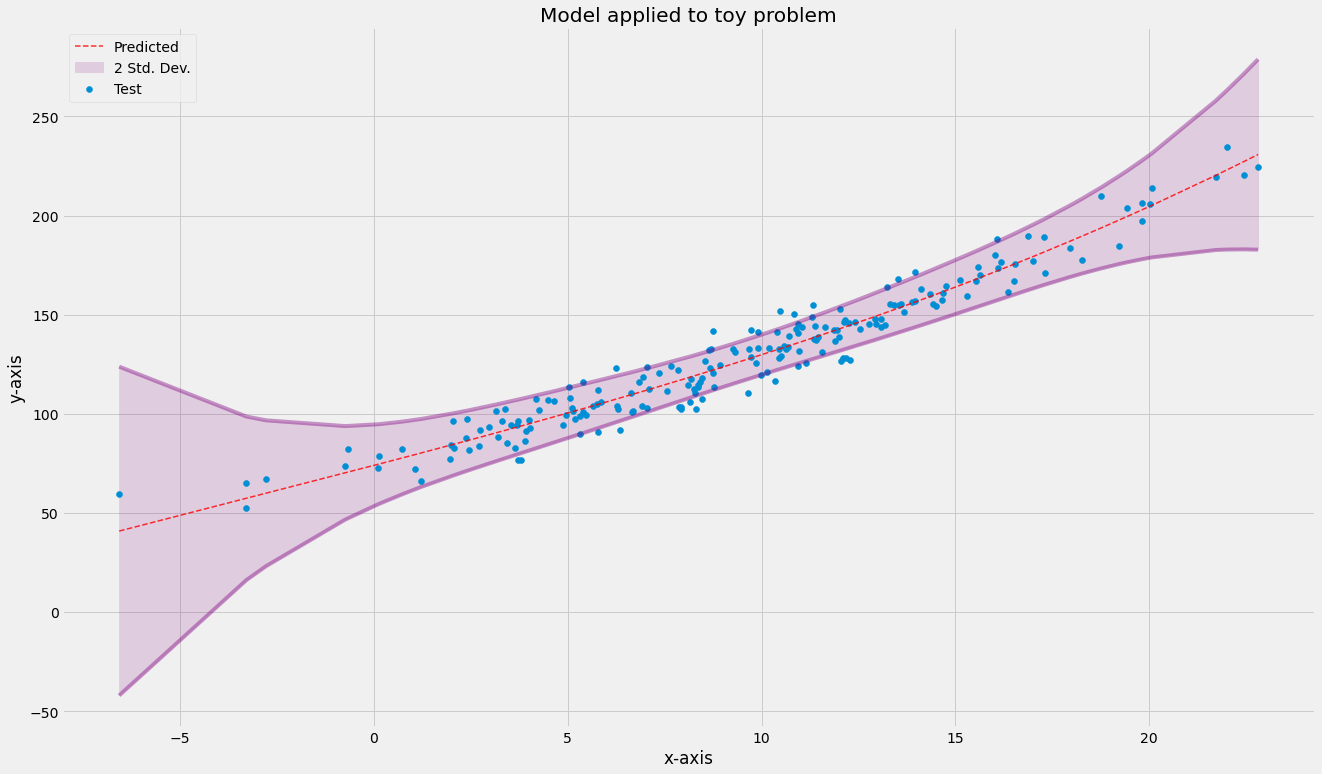

In [148]:
k = 2e7
df_pred = pd.DataFrame(x_test[0], columns = ['x_test'])
df_pred['y_test'] = y_test
df_pred['y_pred'] = y_pred
df_pred['std'] = std
df_pred['lower'] = y_pred - k*std
df_pred['upper'] = y_pred + k*std
df_pred.sort_values(by = ['x_test'], inplace = True)



plt.fill_between(df_pred['x_test'],df_pred['upper'],df_pred['lower'],
                 alpha = 0.15,
                 color = 'purple',
                 label = '2 Std. Dev.')

plt.plot(df_pred['x_test'],df_pred['upper'],
                 color = 'purple', alpha = 0.4)
plt.plot(df_pred['x_test'],df_pred['lower'],
                 color = 'purple', alpha = 0.4)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 1.5,
            alpha = 0.8,
         linestyle = '--',
         label = 'Predicted')


plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Model applied to toy problem')
plt.legend()

# Import and process data

In [159]:
df = pd.read_csv('maize_major_yield/maize_major_yield.csv')
#df = df.drop(['year'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Run Model to Predict Crop Yield

In [160]:
GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = 10, 
                         scale = 1e-6)

GP.train(x_train, y_train)

y_pred, MSE, std = GP.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.6301167908315842


In [161]:
# unnormalize
y_test = unnormalize(y_test, test[1][-1],  test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

(-10.0, 30.0)

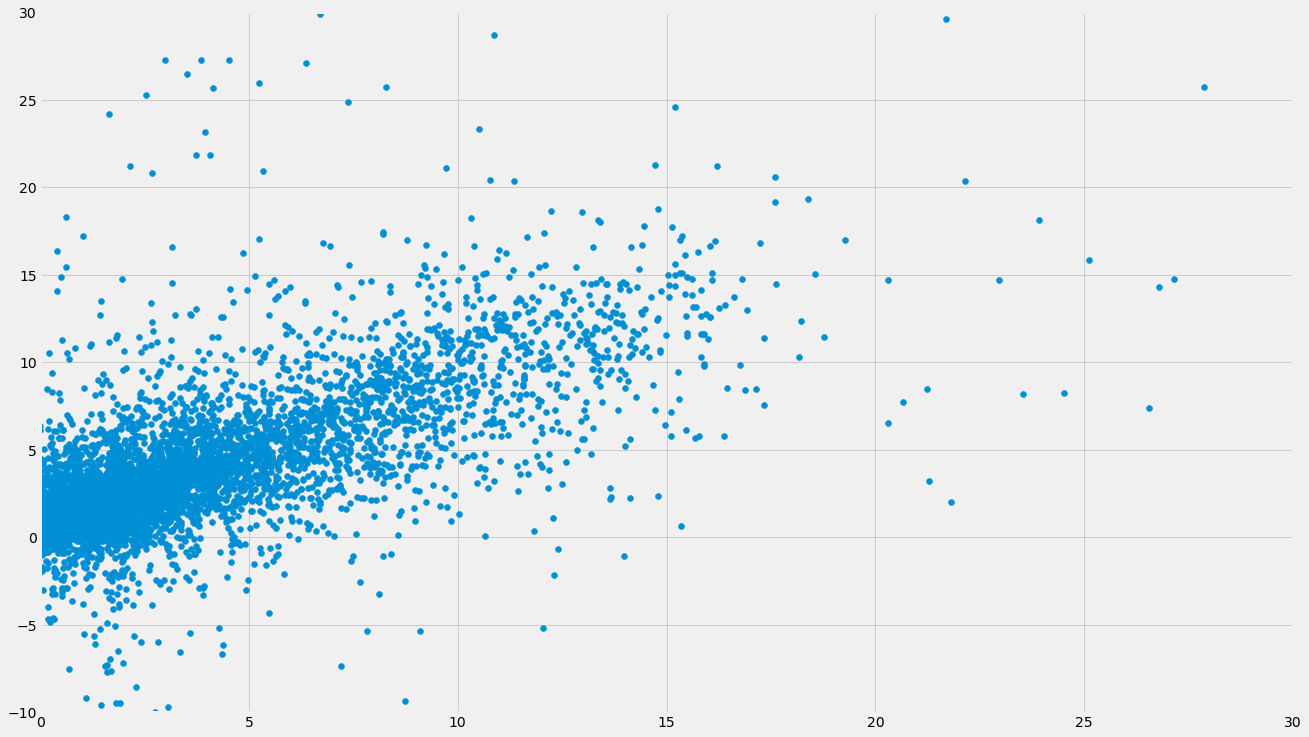

In [162]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'])
plt.xlim(0,30)
plt.ylim(-10,30)

In [163]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.568996
y_pred,0.568996,1.000000


# Hyperparameter optimization with test data

In [14]:
# this will take awhile 
# uses grid search optimization
l_space = list(range(100,310,10))
scale_space = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for lv in l_space:
    for s in scale_space:
    
        iteration += 1

        # start timer
        start = time.time()

        GP = Gaussian_Regression(x_train, y_train, x_test, y_test, 
                         l = lv, 
                         scale = s)

        GP.train(x_train, y_train)

        y_pred, MSE, std = GP.predict(x_test)

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[lv, s]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        #print("Current Step:", step, ' MSE: ', MSE)
        if MSE < previous_MSE:
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209


# Save Optimal Hyperparameters

In [291]:
i = best_results['iteration']
results[i]

{'params': [120, 1e-09],
 'MSE': 11.388855422409483,
 'runtime': 158.3600652217865}

In [292]:
best_l = results[i]['params'][0]
best_scale = results[i]['params'][1]

# Run Gaussian Regression on validation data with optimal hyperparameters

In [293]:
GP = Gaussian_Regression(x_train, y_train, x_valid, y_valid, 
                         l = best_l, 
                         scale = best_scale)

GP.train(x_train, y_train)

y_pred, MSE, std = GP.predict(x_valid)

In [294]:
y_pred = unnormalize(y_pred, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

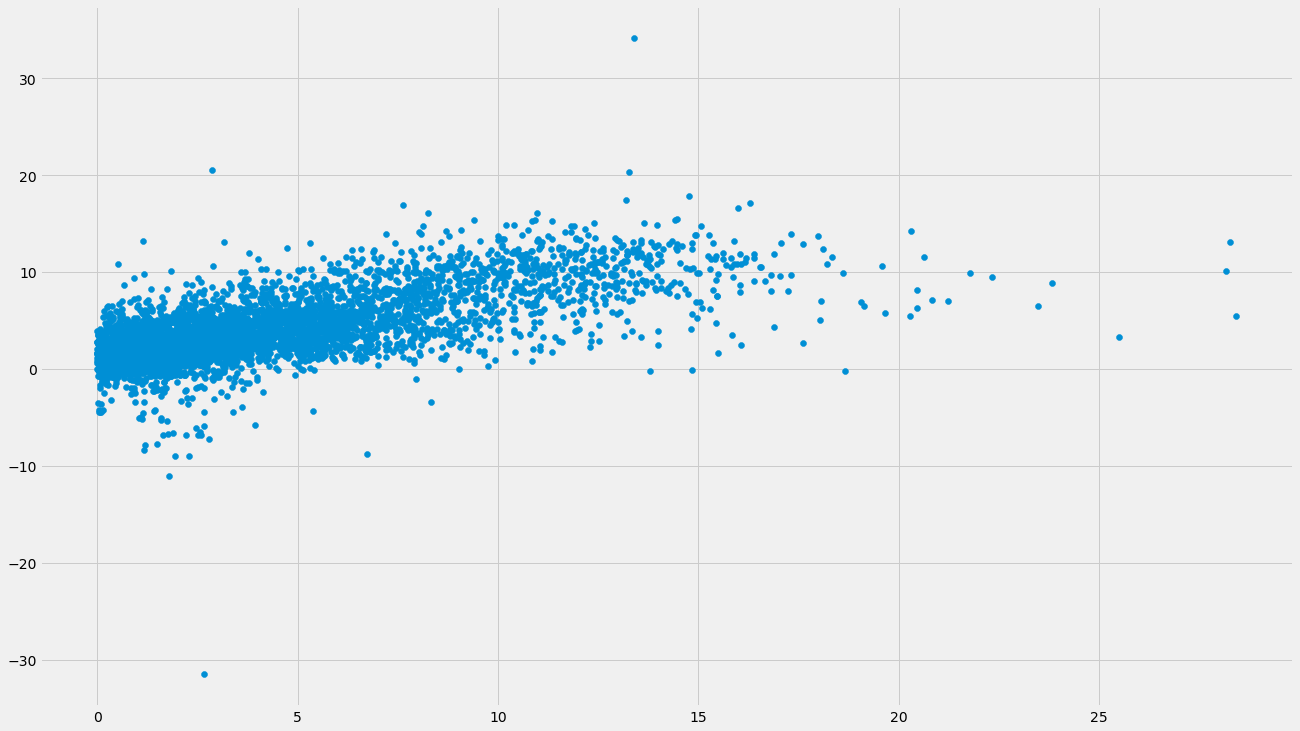

In [295]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

# Evaluate final optimized model

In [296]:
df_pred.corr()

,y_valid,y_pred
y_valid,1.000000,0.718335
y_pred,0.718335,1.000000


In [297]:
GP.MSE(df_pred['y_valid'], df_pred['y_pred'])

3.467298358251374

In [298]:
GP.MAE(df_pred['y_valid'], df_pred['y_pred'])

1.785508062764245

In [299]:
x = []
y = []
for i in range(0,100):
    i = i / 10
    x.append(i)
    y.append( sum( (df_pred['y_pred'] > df_pred['y_valid'] - i)  & (df_pred['y_pred'] < df_pred['y_valid'] + i) ) / len(df_pred) )

Text(0, 0.5, 'Ratio correct')

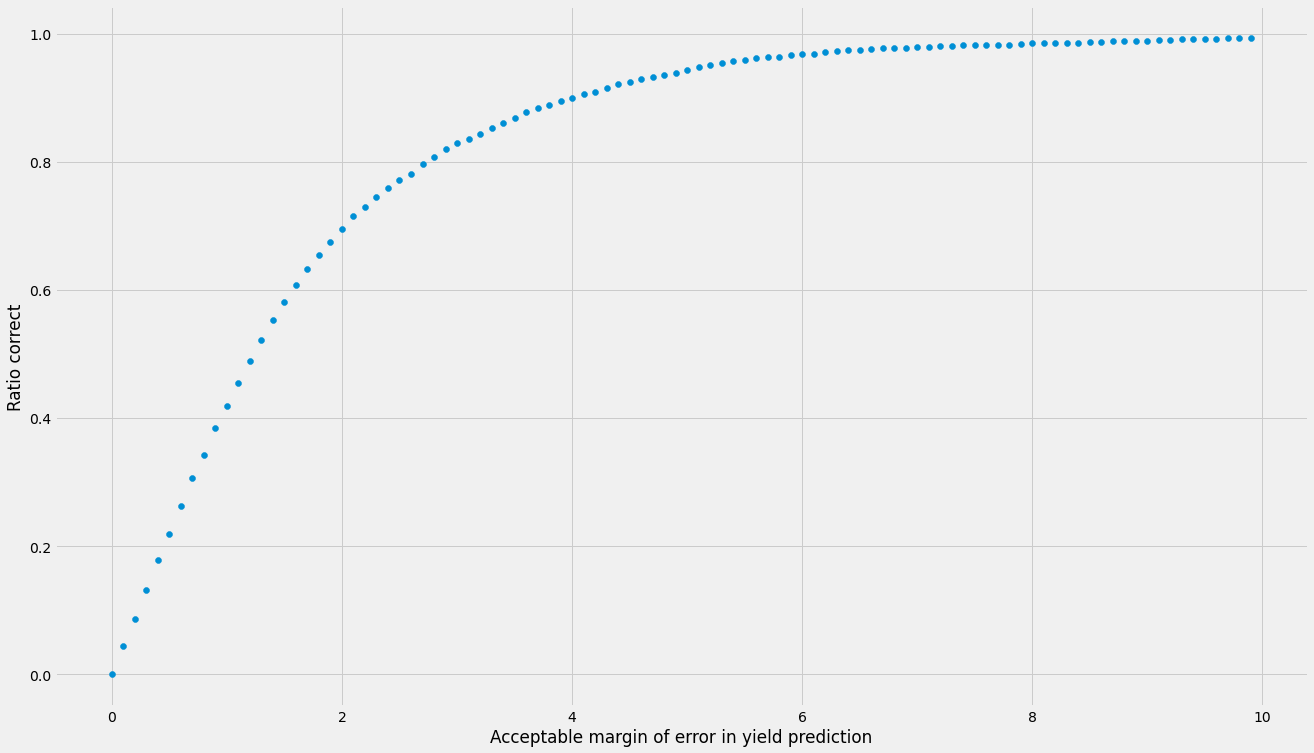

In [301]:
plt.scatter(x,y)
plt.xlabel('Acceptable margin of error in yield prediction')
plt.ylabel('Ratio correct')

In [302]:
sum( (df_pred['y_pred'] > df_pred['y_valid'] - 2)  & (df_pred['y_pred'] < df_pred['y_valid'] + 2) ) / len(df_pred)

0.6953851000157505

# Investigate optimization space

Text(0.5, 1.0, ' Error vs length Hyperparameter')

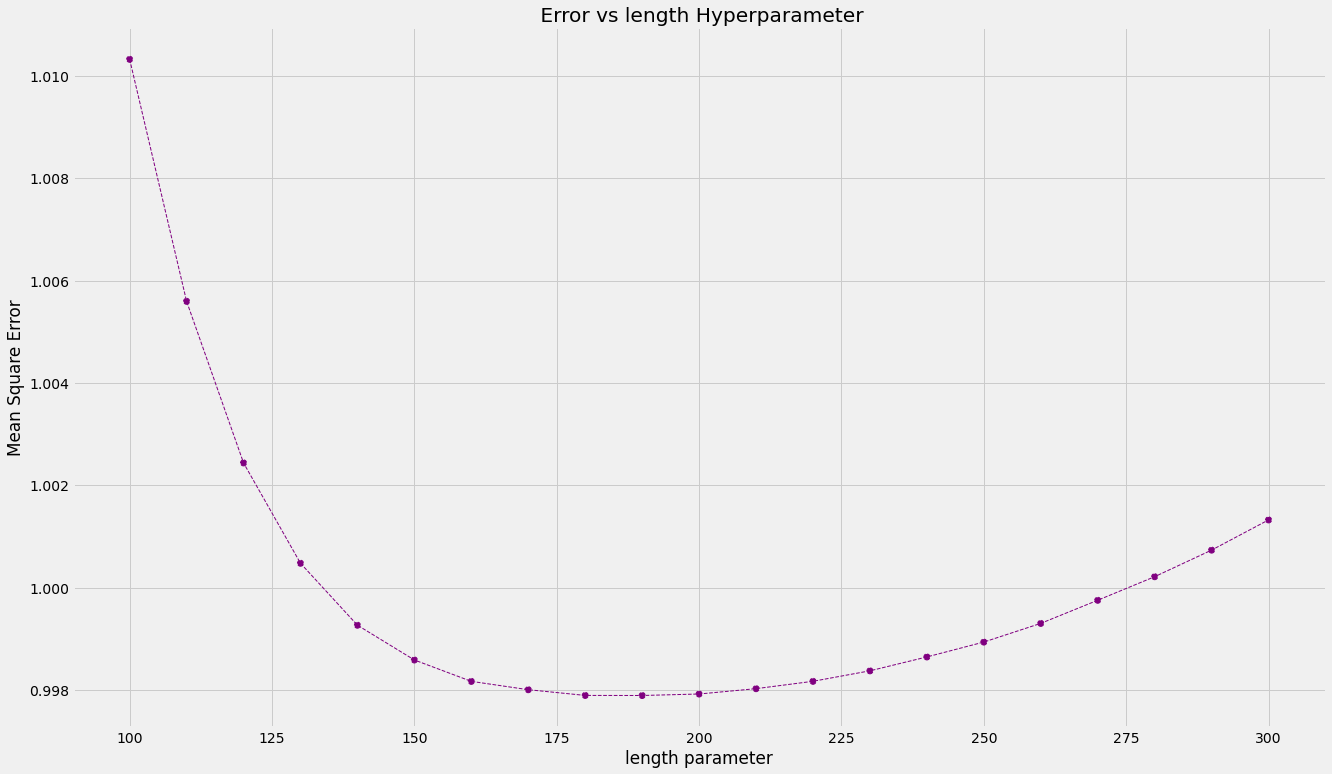

In [234]:
s = []
mse = []
for r in results:
    if r['params'][1] == 1e-10:
        s.append(r['params'][0])
        mse.append(r['MSE'])

plt.plot((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Length parameter')
plt.ylabel('Mean Square Error')
plt.title(' Error vs length Hyperparameter')

Text(0.5, 1.0, ' Runtime vs length Hyperparameter')

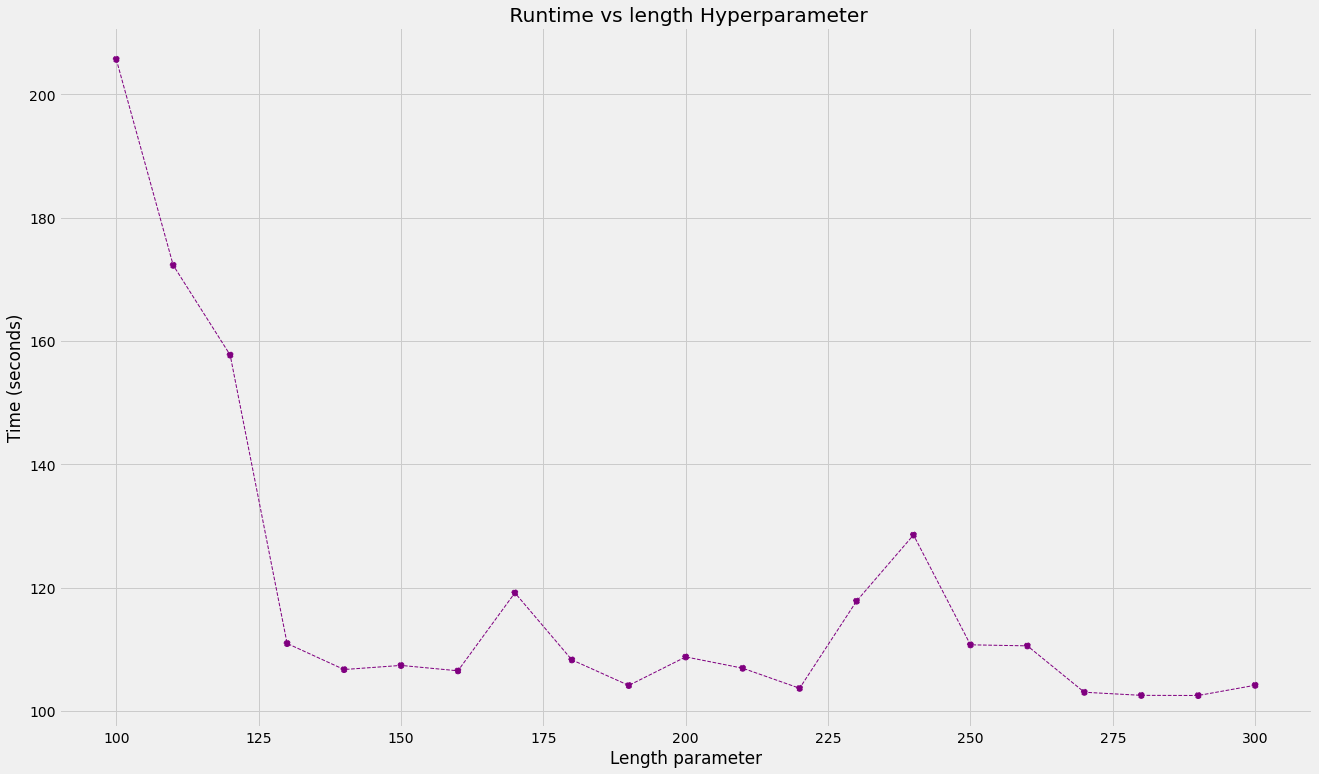

In [238]:
s = []
mse = []
for r in results:
    if r['params'][1] == 1e-10:
        s.append(r['params'][0])
        mse.append(r['runtime'])

plt.plot((s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('Length parameter')
plt.ylabel('Time (seconds)')
plt.title(' Runtime vs length Hyperparameter')

Text(0.5, 1.0, ' Error vs scale Hyperparameter')

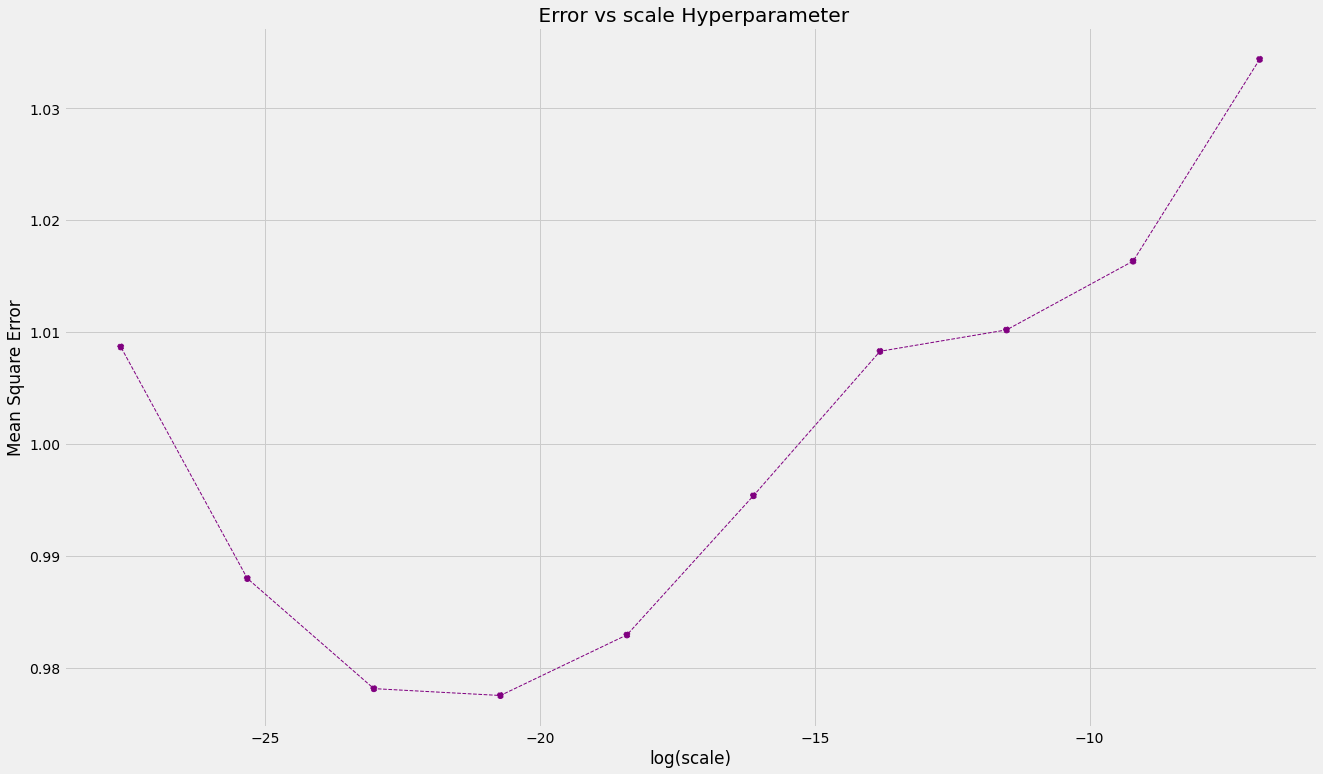

In [236]:
s = []
mse = []
for r in results:
    if r['params'][0] == 150:
        s.append(r['params'][1])
        mse.append(r['MSE'])

plt.plot(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(scale)')
plt.ylabel('Mean Square Error')
plt.title(' Error vs scale Hyperparameter')

Text(0.5, 1.0, ' Runtime vs scale Hyperparameter')

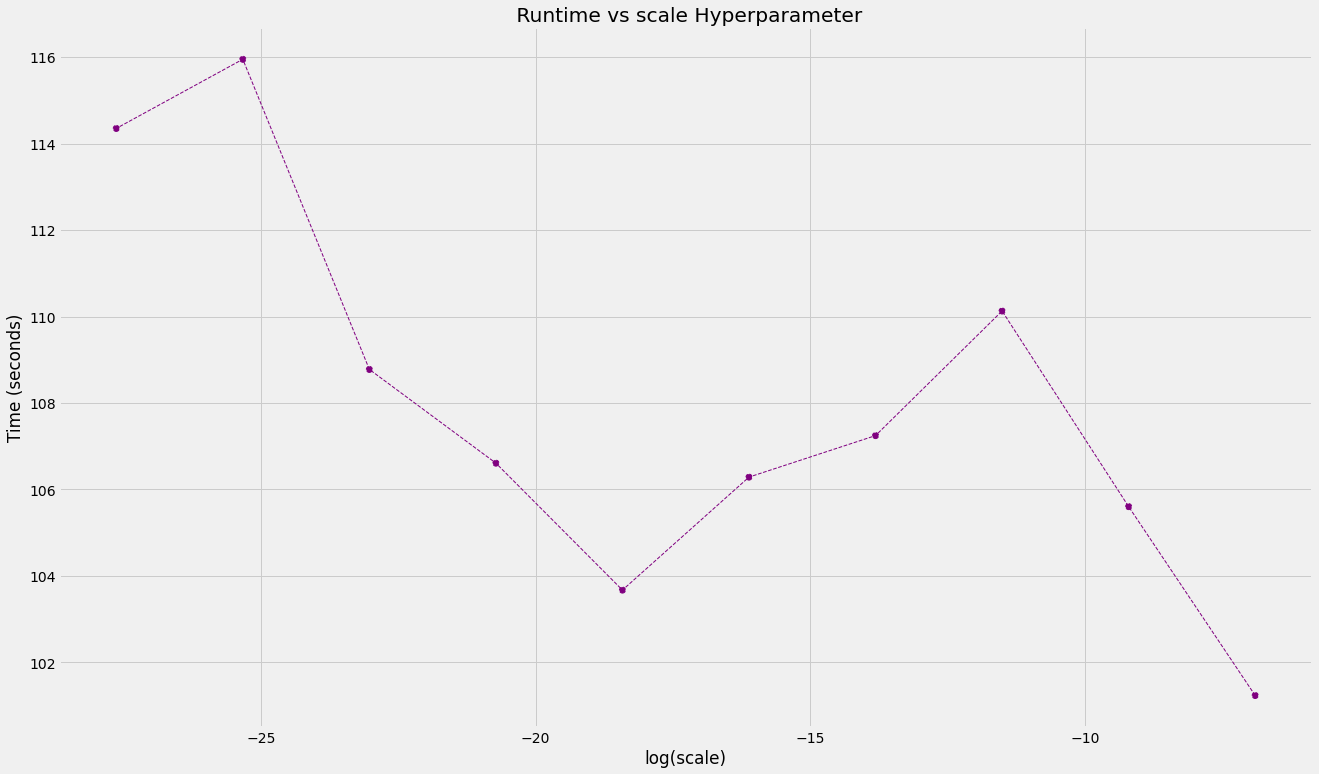

In [239]:
s = []
mse = []
for r in results:
    if r['params'][0] == 200:
        s.append(r['params'][1])
        mse.append(r['runtime'])

plt.plot(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter(np.log(s), mse , c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('log(scale)')
plt.ylabel('Time (seconds)')
plt.title(' Runtime vs scale Hyperparameter')

# Run model on training data to detect overfitting

In [269]:
GP = Gaussian_Regression(x_train, y_train, x_train, y_train, 
                         l = best_l, 
                         scale = best_scale)

GP.train(x_train, y_train)

y_pred, MSE, std = GP.predict(x_train)

In [270]:
y_pred_ontrain = unnormalize(y_pred, train[1][-1],  train[2][-1])
y_train = unnormalize(y_train, train[1][-1],  train[2][-1])

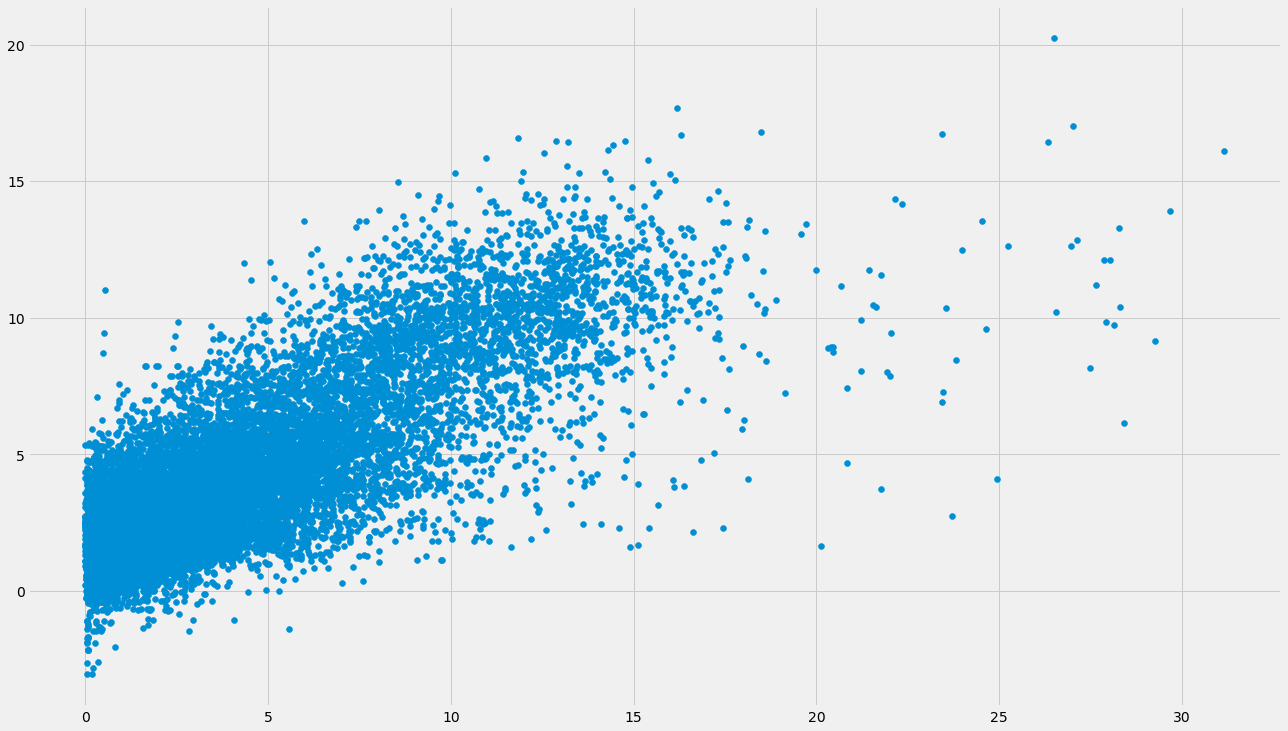

In [271]:
df_pred = pd.DataFrame(list(y_train), columns = ['y_train'])
df_pred['y_pred'] = list(y_pred_ontrain)

plt.scatter(df_pred['y_train'], df_pred['y_pred'])

In [272]:
df_pred.corr()

,y_train,y_pred
y_train,1.000000,0.814493
y_pred,0.814493,1.000000
